### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from tqdm.notebook import tqdm
from neuropy.core import Epoch
from neuropy.utils.mathutil import min_max_scaler
from neuropy import plotting
from scipy import stats
import pandas as pd
import subjects

### Signficant sequences(wcorr) compare SD vs NSD 

In [ ]:
sessions = subjects.pf_sess()

replay_df = []
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    zt_starts = np.array([0, 2.5, 5])
    zt_stops = np.array([2.5, 5, 7.5])
    epochs = np.vstack((zt_starts, zt_stops)).T * 3600 + post[0]
    epochs = np.insert(epochs, 0, maze, axis=0)
    labels = ["MAZE", "0-2.5", "2.5-5", "5-7.5"]

    for i, (t1, t2) in enumerate(epochs):
        replay_pbe = sess.replay_pbe.time_slice(t1, t2).to_dataframe()
        for direction in ["up", "down"]:
            perc = replay_pbe[direction + "_percentile_score"].values
            is_replay = (perc <= 5) | (perc >= 95)
            scores = replay_pbe[direction + "_score"].values[is_replay]
            order = replay_pbe[direction + "_replay_order"].values[is_replay]
            order, counts = np.unique(order, return_counts=True)
            df = pd.DataFrame(
                dict(
                    zt=labels[i],
                    replay_order=["r"],
                    prop=counts.sum() / len(replay_pbe),
                    # scores=np.abs(scores),
                    animal=sub,
                    grp=sess.tag,
                )
            )
            replay_df.append(df)

replay_df = pd.concat(replay_df, ignore_index=True)

# subjects.GroupData().save(replay_df,'replay_sig_frames')

In [ ]:
_, ax = plt.subplots()
sns.barplot(data=replay_df, x="zt", y="prop", hue="grp")

### Distributions of wcorr SD vs NSD
- This is based on suggestions of not using comparisons with shuffles

In [ ]:
sessions = subjects.pf_sess()

replay_df = []
for sub, sess in enumerate(sessions):
    neurons = sess.neurons_stable.get_neuron_type(["pyr", "mua"])
    neurons = neurons[neurons.firing_rate <= 10]
    pbe_filter = sess.pbe_filters.to_dataframe()

    good_bool = (
        pbe_filter.is_rpl
        & pbe_filter.is_5units
        # & pbe_filter.is_lowtheta
        & pbe_filter.is_rest
    )

    replay_pbe = sess.replay_wcorr_mua[good_bool.values].to_dataframe()
    radon_df = sess.replay_radon_mua[good_bool.values].to_dataframe()

    starts = sess.replay_pbe.starts

    starts = replay_pbe.start.values

    up_wcorr = replay_pbe["up_score"].values
    down_wcorr = -replay_pbe["down_score"].values

    up_radon = radon_df["up_score"].values
    down_radon = radon_df["down_score"].values

    # wcorr = np.maximum(np.abs(up_wcorr),np.abs(down_wcorr))
    # wcorr = np.concatenate([np.abs(up_wcorr),np.abs(down_wcorr)])

    best_bool = np.abs(up_radon) > np.abs(down_radon)
    wcorr = np.zeros(len(replay_pbe))
    wcorr[best_bool] = up_wcorr[best_bool]
    wcorr[~best_bool] = down_wcorr[~best_bool]

    # thresh_bool=np.abs(wcorr)>0.5
    # wcorr = wcorr[thresh_bool]
    # starts = starts[thresh_bool]

    epochs = sess.get_zt_epochs()
    pre = epochs["PRE"].flatten()
    pre_indx = (starts > pre[0]) & (starts < pre[1])
    wcorr_pre = np.abs(wcorr[pre_indx])
    mean_pre = wcorr_pre.mean()

    for i, e in enumerate(epochs.itertuples()):
        indx = (starts > e.start) & (starts < e.stop)
        wcorr_e = wcorr[indx]
        percentile = np.array(
            [
                stats.percentileofscore(wcorr_pre, wcorr_e[i], kind="strict")
                for i in range(len(wcorr_e))
            ]
        )

        df = pd.DataFrame(
            dict(
                zt=e.label,
                wcorr=np.abs(wcorr_e),
                perc=percentile,
                session=sub,
                name=sess.animal.name,
                grp=sess.tag,
            )
        )
        replay_df.append(df)

replay_df = pd.concat(replay_df, ignore_index=True)

In [ ]:
from plotters import violinplot

df = replay_df[replay_df.name != "RatK"]
_, ax = plt.subplots()
violinplot(data=df, x="zt", y="wcorr", stat_anot=True)

### Distribution of static events
- Do SD sessions have greater propoensity for replaying static events
- Probability of occurence looks similar

In [ ]:
sessions = subjects.pf_sess()

vel_df = []
for sub, sess in enumerate(sessions):
    replay_pbe = sess.replay_radon_mua.to_dataframe()
    starts = replay_pbe.start.values

    up_score = replay_pbe.up_score.values
    up_vel = replay_pbe.up_velocity.values
    down_score = replay_pbe.down_score.values
    down_vel = replay_pbe.down_velocity.values

    best_bool = up_score > down_score
    score = np.zeros(len(starts))
    score[best_bool] = up_score[best_bool]
    score[~best_bool] = down_score[~best_bool]

    vel = np.zeros(len(starts))
    vel[best_bool] = up_vel[best_bool]
    vel[~best_bool] = down_vel[~best_bool]

    epochs = sess.get_zt_epochs(include_maze=True)

    period = epochs["PRE"].flatten()
    period_indx = (starts > period[0]) & (starts < period[1])
    mean_period = score[period_indx].mean()

    for i, e in enumerate(epochs.itertuples()):
        indx = (starts > e.start) & (starts < e.stop)
        vel_e = vel[indx]
        vel_bool = np.abs(vel_e) < 50
        static_prportion = np.count_nonzero(vel_bool) / len(vel_e)
        vel_df.append(
            pd.DataFrame(
                {
                    "zt": e.label,
                    "prob": [static_prportion],
                    "session": sub,
                    "grp": sess.tag,
                }
            )
        )

vel_df = pd.concat(vel_df, ignore_index=True)

In [ ]:
_, ax = plt.subplots()

sns.stripplot(data=vel_df, x="zt", y="prob", hue="grp", split=True)

### Wcorr-Radon 2d histogram SD vs NSD

In [ ]:
sessions = subjects.pf_sess()

rw_df = []
for sub, sess in enumerate(sessions):
    pbe = sess.pbe.to_dataframe()
    radon_df = sess.replay_radon_mua.to_dataframe()
    wcorr_df = sess.replay_wcorr_mua.to_dataframe()

    # wcorr_df = sess.replay_pbe[good_bool].to_dataframe()
    # radon_df = sess.replay_radon[good_bool].to_dataframe()

    starts = radon_df.start.values

    up_wcorr = wcorr_df["up_score"].values
    down_wcorr = -wcorr_df["down_score"].values

    up_radon = radon_df.up_score.values
    up_vel = radon_df.up_velocity.values
    down_radon = radon_df.down_score.values
    down_vel = -radon_df.down_velocity.values

    best_bool = np.abs(up_wcorr) > np.abs(down_wcorr)
    wcorr = np.zeros(len(starts))
    wcorr[best_bool] = up_wcorr[best_bool]
    wcorr[~best_bool] = down_wcorr[~best_bool]

    radon = np.zeros(len(starts))
    radon[best_bool] = up_radon[best_bool]
    radon[~best_bool] = down_radon[~best_bool]

    vel = np.zeros(len(starts))
    vel[best_bool] = up_vel[best_bool]
    vel[~best_bool] = down_vel[~best_bool]

    epochs = sess.get_zt_epochs()
    period = epochs["PRE"].flatten()
    period_indx = (starts > period[0]) & (starts < period[1])
    mean_period_wcorr = np.abs(wcorr[period_indx]).mean()
    mean_period_radon = radon[period_indx].mean()

    for i, e in enumerate(epochs.itertuples()):
        indx = (starts > e.start) & (starts < e.stop)
        rw_df.append(
            pd.DataFrame(
                {
                    "zt": e.label,
                    "radon": radon[indx] / mean_period_radon,
                    # 'radon':np.abs(vel[indx]),
                    "wcorr": np.abs(wcorr[indx]),
                    "session": sub,
                    "grp": sess.tag,
                }
            )
        )

rw_df = pd.concat(rw_df, ignore_index=True)

In [ ]:
_, axs = plt.subplots(4, 5, sharex=True, sharey=True)

nbins = 30
xbins = np.linspace(0, 3, nbins)
ybins = np.linspace(0, 1, nbins)

zts = rw_df.zt.unique()

for i, zt in enumerate(zts[:1]):
    df = rw_df[(rw_df.zt == zt) & (rw_df.radon < 10000)]

    # ax=axs[0,i]
    # sns.histplot(data=df,x='radon',y='wcorr',hue='grp',ax=ax)

    hist_pre = []
    for g, grp in enumerate(["NSD", "SD"]):
        x = df[df.grp == grp].radon.values
        y = df[df.grp == grp].wcorr.values

        score_hist = np.histogram2d(x, y, bins=[xbins, ybins])[0]
        hist_pre.append(score_hist / np.sum(score_hist))


for i, zt in enumerate(zts):
    df = rw_df[(rw_df.zt == zt) & (rw_df.radon < 10000)]

    # ax=axs[0,i]
    # sns.histplot(data=df,x='radon',y='wcorr',hue='grp',ax=ax)

    hist_all = []
    for g, grp in enumerate(["NSD", "SD"]):
        x = df[df.grp == grp].radon.values
        y = df[df.grp == grp].wcorr.values

        score_hist = np.histogram2d(x, y, bins=[xbins, ybins])[0]
        norm_hist = score_hist / np.sum(score_hist)
        hist_all.append(norm_hist)

        ax = axs[g, i]
        # hist_diff = hist_all[0]-hist_all[1]
        ax.pcolormesh(xbins, ybins, norm_hist, cmap="jet", vmin=-0.01, vmax=0.01)

        ax = axs[3, i]
        sns.regplot(
            x=x,
            y=y,
            color=subjects.colors_sd()[g],
            ax=ax,
            scatter=False,
            scatter_kws=dict(s=2),
        )

    axs[2, i].pcolormesh(
        xbins, ybins, hist_all[0] - hist_all[1], cmap="jet", vmin=-0.002, vmax=0.002
    )

    # ax=axs[3,i]
    # ax.scatter(x,y,s=2)

### Examples for figure4 sd paper

In [ ]:
sessions = subjects.nsd.ratSday2 + subjects.sd.ratSday3
events = [
    [74, 344, 737, 897, 1727, 3727, 4900, 5613, 6851, 6164],
    [877, 1011, 1579, 1675, 3726, 2943, 5736, 5666, 6944, 7564],
]

replay_example_dict = {}
for sub, sess in enumerate(sessions):
    replay = sess.replay_pbe
    replay_df = sess.replay_pbe.to_dataframe()
    starts = sess.replay_pbe.starts
    wcorr, scores, posteriors = [], [], []
    for i, d in enumerate(["up", "down"]):
        scores.append(replay_df[d + "_percentile_score"].values)
        posteriors.extend(replay.metadata[d + "_posterior"])
        wcorr.append(replay_df[d + "_score"].values)
    wcorr = np.concatenate(wcorr)
    replay_example_dict[sess.tag] = dict(
        posteriors=[posteriors[p] for p in events[sub]], wcorr=wcorr[events[sub]]
    )


subjects.GroupData().save(replay_example_dict, "replay_examples")

### Mean replay score across all events as a function of time 

In [7]:
from neuropy.core import Epoch

sessions = subjects.pf_sess()

replay_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    replay_pbe = sess.replay_pbe_mua.to_dataframe()
    starts = sess.pbe.starts

    up_score = replay_pbe.up_radon.values
    # up_vel = replay_pbe.up_velocity.values
    down_score = replay_pbe.down_radon.values
    # down_vel = replay_pbe.down_velocity.values

    score = np.maximum(up_score, down_score)

    epochs = sess.get_zt_epochs()
    epochs = epochs[:2]
    mean_pre = stats.binned_statistic(
        starts, score, bins=epochs["MAZE"].flatten(), statistic="mean"
    )[0]
    std_pre = stats.binned_statistic(
        starts, score, bins=epochs["MAZE"].flatten(), statistic="std"
    )[0]

    score = score / mean_pre

    post_bins = np.arange(post[0], post[0] + 8 * 3600, 900)
    post_epochs = Epoch.from_array(
        post_bins[:-1],
        post_bins[1:] - 0.01,
        np.arange(len(post_bins) - 1) * (900 / 3600),
    )

    epochs = post_epochs

    mean_score = stats.binned_statistic(
        starts, score, bins=epochs.flatten(), statistic="mean"
    )[0][::2]

    replay_df.append(
        pd.DataFrame(
            {
                "zt": epochs.labels.astype(float),
                "score": mean_score,
                "session": sub,
                "name": sess.animal.name + sess.animal.day,
                "grp": sess.tag,
            }
        )
    )

replay_df = pd.concat(replay_df, ignore_index=True)

#Sessions = 13


meta NOT subset; don't know how to subset; dropped


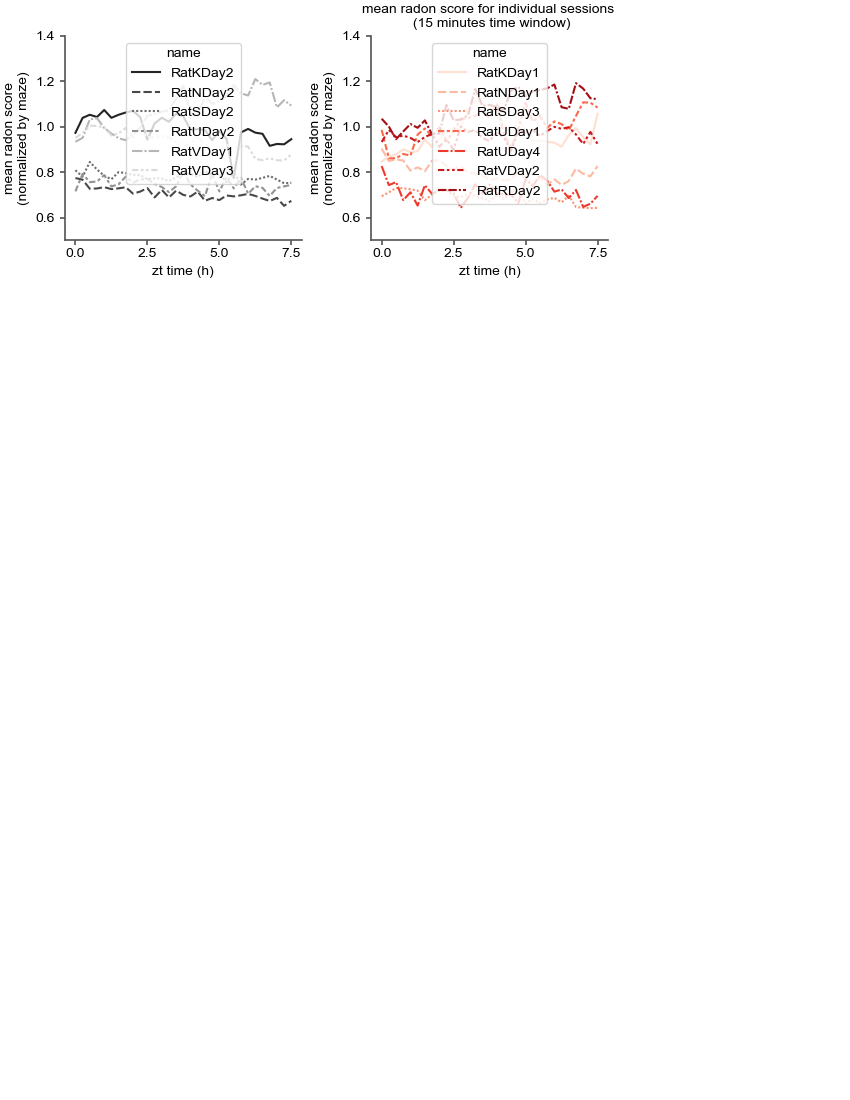

In [37]:
fig = plotting.Fig(grid=(5, 3), fontsize=10)

# _,ax = plt.subplots()
ax = fig.subplot(fig.gs[0, 0])
sns.lineplot(
    data=replay_df[replay_df.grp == "NSD"],
    x="zt",
    y="score",
    hue="name",
    # units="name",
    # size='name',
    style="name",
    estimator=None,
    ax=ax,
    palette="gray",
    legend="full",
)
ax.set_xticks([0, 2.5, 5, 7.5])
# ax.legend([],frameon=false)
ax.set_ylabel("mean radon score\n(normalized by maze)")
ax.set_xlabel("zt time (h)")
ax.set_ylim(0.5, 1.4)

ax = fig.subplot(fig.gs[0, 1])
sns.lineplot(
    data=replay_df[replay_df.grp == "SD"],
    x="zt",
    y="score",
    hue="name",
    # units="name",
    # size='name',
    style="name",
    estimator=None,
    ax=ax,
    # palette=[subjects.colors_sd(1)[1]],
    palette="Reds",
    legend="full",
)
ax.set_xticks([0, 2.5, 5, 7.5])
# ax.legend([],frameon=false)
ax.set_ylabel("mean radon score\n(normalized by maze)")
ax.set_xlabel("zt time (h)")
ax.set_title("mean radon score for individual sessions \n (15 minutes time window)")
ax.set_ylim(0.5, 1.4)

fig.savefig(subjects.figpath_sd / "mean_radon_score_over_time")

### Distribution of replay scores and comparison with shuffled scores

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import subjects
from neuropy import plotting
from neuropy.utils import signal_process
from neuropy.analyses import Pf1D
from neuropy.analyses import Decode1d

sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4

In [ ]:
from scipy import stats

score_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    replay_pbe = sess.replay_pbe.to_dataframe()

    starts = sess.replay_pbe.starts
    replay_score = replay_pbe.score

    shuffle_scores = sess.replay_pbe.metadata["shuffle_score"].flatten()
    shuffle_starts = np.repeat(starts, 200)

    bins = np.arange(2) * 3600 + post[0]
    replay_df = pd.DataFrame(
        {
            "Zt": np.digitize(starts, bins),
            "starts": starts,
            "score": replay_score,
            "grp": sess.tag,
        }
    )
    shuffle_df = pd.DataFrame(
        {
            "Zt": np.digitize(shuffle_starts, bins),
            "starts": shuffle_starts,
            "score": shuffle_scores,
            "grp": f"{sess.tag}_shuffle",
        }
    )
    score_df.append(pd.concat([replay_df, shuffle_df]))

score_df = pd.concat(score_df, ignore_index=True)

In [ ]:
sess.replay_pbe.metadata["shuffle_score"].shape

In [ ]:
from neuropy import plotting
import seaborn as sns

fig = plotting.Fig(grid=(2, 2))
ax = fig.subplot(fig.gs[0])
sns.violinplot(data=score_df, x="Zt", y="score", hue="grp")

### Which positions are being replayed the most in POST

In [ ]:
sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4

In [ ]:
import scipy.signal as sg
from scipy.ndimage import gaussian_filter1d

mean_posterior = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    starts = sess.replay_pbe.starts
    ind = (starts >= post[0] + 2.5 * 3600) & (starts <= post[0] + 5 * 3600)

    posteriors = sess.replay_pbe.metadata["up_posterior"]
    posteriors = [posteriors[_] for _ in np.argwhere(ind).squeeze()]
    mean_posterior.append(np.hstack(posteriors).mean(axis=1))

In [ ]:
_, axs = plt.subplots(1, 2, sharey=True)

for i, p in enumerate(mean_posterior):
    axs[i].plot(p)

### Forward and reverse replay during POST SD vs NSD 

In [ ]:
sessions = subjects.pf_sess()

In [ ]:
from replay_funcs import get_jump_distance

replay_df = []
jd_df = []
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    replay_pbe_df = sess.replay_pbe.to_dataframe()
    metadata = sess.replay_pbe.metadata

    wcorr_up = replay_pbe_df["up_score"].values
    seq_score_up = replay_pbe_df["up_sequence_score"].values
    percentile_up = replay_pbe_df["up_percentile_score"].values
    jd_up = get_jump_distance(metadata["up_posterior"], "max")

    wcorr_down = -replay_pbe_df["down_score"].values
    seq_score_down = replay_pbe_df["down_sequence_score"].values
    percentile_down = 100 - replay_pbe_df["down_percentile_score"].values
    jd_down = get_jump_distance(metadata["down_posterior"], "max")

    best_bool = np.abs(wcorr_up) > np.abs(wcorr_down)

    wcorr = np.zeros(len(replay_pbe_df))
    wcorr[best_bool] = wcorr_up[best_bool]
    wcorr[~best_bool] = wcorr_down[~best_bool]

    seq_score = np.zeros(len(replay_pbe_df))
    seq_score[best_bool] = seq_score_up[best_bool]
    seq_score[~best_bool] = seq_score_down[~best_bool]

    percentile = np.zeros(len(replay_pbe_df))
    percentile[best_bool] = percentile_up[best_bool]
    percentile[~best_bool] = percentile_down[~best_bool]

    jd = np.zeros(len(replay_pbe_df))
    jd[best_bool] = jd_up[best_bool]
    jd[~best_bool] = jd_down[~best_bool]

    is_forward = (wcorr > 0) & ((percentile < 2.5) | (percentile > 97.5))
    is_reverse = (wcorr < 0) & ((percentile < 2.5) | (percentile > 97.5))

    zt_starts = np.array([0, 2.5, 5])
    zt_stops = np.array([2.5, 5, 7.5])
    epochs = np.vstack((zt_starts, zt_stops)).T * 3600 + post[0]
    epochs = np.insert(epochs, 0, maze, axis=0)
    labels = ["MAZE", "0-2.5", "2.5-5", "5-7.5"]

    for i, (t1, t2) in enumerate(epochs):
        indx = (replay_pbe_df.start > t1) & (replay_pbe_df.start < t2)
        n_pbes = np.count_nonzero(indx)
        df = pd.DataFrame(
            dict(
                zt=labels[i],
                replay_order=["forward", "reverse"],
                prop=[
                    np.count_nonzero(is_forward[indx]) / n_pbes,
                    np.count_nonzero(is_reverse[indx]) / n_pbes,
                ],
                jd=jd[indx].mean(),
                animal=sub,
                grp=sess.tag,
            )
        )
        replay_df.append(df)

replay_df = pd.concat(replay_df, ignore_index=True)

# subjects.GroupData().save(replay_df, "replay_order")

In [ ]:
# _,ax = plt.subplots(1,1)
# sns.barplot(data=replay_df,x='zt',y='perc',hue='grp',ax=ax, ci =99)

_, axs = plt.subplots(1, 2, sharey=True)

for i, odr in enumerate(["forward", "reverse"]):
    ax = axs[i]
    df = replay_df[replay_df["replay_order"] == odr]
    sns.boxplot(
        data=df,
        x="zt",
        y="prop",
        hue="grp",
        ax=ax,
        # split=True,
        showfliers=False,
        # estimator=np.median,
        palette=subjects.colors_sd(1.4),
        dodge=True,
        # join=False,
        # width='area',
        # stat="probability",
        # common_norm=False,
        # cumulative=True,
        # showfliers=False,
    )
    # print(stats.ttest_ind(d1, d2,alternative='greater'))
    ax.set_title(odr)
    ax.set_ylim([0, 0.3])


# ax = axs[2]
# sns.boxplot(
#     data=df,
#     x="zt",
#     y="jd",
#     hue="grp",
#     ax=ax,
#     # split=True,
#     showfliers=False,
#     # estimator=np.median,
#     palette=subjects.colors_sd(1.4)
#     # dodge=True,
#     # join=False,
#     # width='area',
#     # stat="probability",
#     # common_norm=False,
#     # cumulative=True,
#     # showfliers=False,
# )
# # print(stats.ttest_ind(d1, d2,alternative='greater'))
# ax.set_title(odr)
# # ax.set_ylim([0,0.3])

### Weighted distance correlation

In [ ]:
from neuropy.analyses.decoders import wcorr
import pingouin as pg

sessions = subjects.pf_sess()


def get_dcorr(arr):
    """weighted correlation"""
    nx, ny = arr.shape[1], arr.shape[0]
    x = np.arange(nx) / nx
    y = np.tile(np.arange(ny)[:, np.newaxis], (1, nx)) * arr
    y = y.mean(axis=0) / ny
    return pg.distance_corr(x, y, n_boot=None)


# rng = np.random.default_rng()

dcorr_df = []
for s, sess in enumerate(sessions):
    starts = sess.replay_pbe.starts

    up_posterior = sess.replay_pbe.metadata["up_posterior"]
    down_posterior = sess.replay_pbe.metadata["down_posterior"]

    up_dcorr = [get_dcorr(_) for _ in up_posterior]
    down_dcorr = [get_dcorr(_) for _ in down_posterior]

    dcorr = np.maximum(up_dcorr, down_dcorr)

    epochs = sess.get_zt_epochs()

    for i, e in enumerate(epochs.itertuples()):
        indx = (starts > e.start) & (starts < e.stop)
        df = pd.DataFrame(
            dict(
                zt=e.label,
                dcorr=dcorr[indx],
                session=sub,
                grp=sess.tag,
            )
        )
        dcorr_df.append(df)

dcorr_df = pd.concat(dcorr_df, ignore_index=True)

In [ ]:
from plotters import violinplot

_, ax = plt.subplots()

violinplot(data=dcorr_df, x="zt", y="dcorr", stat_anot=True)